# Installations & Imports

In [ ]:
! pip install pretty_midi
! pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.6 MB 4.7 MB/s 
     |████████████████████████████████| 51 kB 7.7 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=a0a0367447696aad78dcd57496d7552b2dd233a2625559f6494504ee2ea60ffa
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 5.2 MB/s 
     |████████████████████████████████| 287 kB 37.8 MB/s 


In [ ]:
# general imports
import pretty_midi
import pandas as pd
import os
import numpy as np
from collections import Counter
import joblib
from statistics import mean
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# NLP imports
import nltk
import contractions
import string
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
nltk.download('punkt')
punctuation = list(string.punctuation)
punctuation.remove('&')

# tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Concatenate, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model 


# sklearn

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# params
VALIDATION_FRAC = 0.2
w2v_size = 300
fs = 5

# paths
midis_path = '/content/MyDrive/Shareddrives/DL-HW3/midi_files/'
train_csv_lyrics_path = '/content/MyDrive/Shareddrives/DL-HW3/lyrics_train_set.csv'
test_csv_lyrics_path = '/content/MyDrive/Shareddrives/DL-HW3/lyrics_test_set.csv'

In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


# Load the data

In [ ]:
cols = ['Singer', 'Song Name', 'Lyrics']

train_set = pd.read_csv(train_csv_lyrics_path)
test_set = pd.read_csv(test_csv_lyrics_path, names=cols)

fixed_train_set = train_set.dropna(axis=1)
fixed_train_set.columns=cols

fixed_train_set

,Singer,Song Name,Lyrics
0,gerry rafferty,baker street,winding your way down on baker street & lite i...
1,gerry rafferty,right down the line,you know i need your love & you've got that ho...
2,2 unlimited,tribal dance,come on check it out ya'll & (come on come on!...
3,2 unlimited,let the beat control your body,let the beat control your body & let the beat ...
4,2 unlimited,get ready for this,ya'll ready for this? & get down with the styl...
...,...,...,...
594,don henley,dirty laundry,i make my living off the evening news & just g...
595,don henley,new york minute,harry got up & dressed all in black & went dow...
596,bob dylan,subterranean homesick blues,johnny's in the basement & mixing up the medic...
597,goldfinger,mable,i met her sunday that was yesterday & the girl...


In [ ]:
def add_midi_file_names(df):
    midis = list(os.listdir(midis_path))
    midis = {midi.lower()[:-4].replace('_', ''): midi for midi in midis}  
    print(midis)  
    
    def combine_singer_song(singer, song):
        key = f'{singer} - {song}'.replace(' ', '').lower()
        return midis[key] if key in midis else None
    
    df['Midi File'] = df.apply(lambda r: combine_singer_song(r['Singer'], r['Song Name']) ,axis=1)
    return df

test_set = add_midi_file_names(test_set)
train_set = add_midi_file_names(fixed_train_set)
train_set

{'dionnewarwick-heartbreaker': 'Dionne_Warwick_-_Heartbreaker.mid', 'blink182-josie': 'Blink_182_-_Josie.mid', 'fredapayne-bandofgold': 'Freda_Payne_-_Band_of_Gold.mid', 'thecorrs-closer': 'The_Corrs_-_Closer.mid', 'annemurray-youneededme': 'Anne_Murray_-_You_Needed_Me.mid', 'abba-knowingmeknowingyou': 'ABBA_-_Knowing_Me_Knowing_You.mid', 'donnasummer-badgirls': 'Donna_Summer_-_Bad_Girls.mid', 'chicago-saturdayinthepark': 'Chicago_-_Saturday_in_the_Park.mid', 'celinedion-becauseyoulovedme': 'Celine_Dion_-_Because_You_Loved_Me.mid', "davidbowie-let'sdance": "David_Bowie_-_Let's_Dance.mid", 'bananarama-cruelsummer': 'Bananarama_-_Cruel_Summer.mid', 'alanparsons-time': 'Alan_Parsons_-_Time.mid', 'badreligion-americanjesus': 'Bad_Religion_-_American_Jesus.mid', 'alanparsons-primetime': 'Alan_Parsons_-_Prime_Time.mid', 'beegees-nightfever': 'Bee_Gees_-_Night_Fever.mid', 'enriqueiglesias-bailamos': 'Enrique_Iglesias_-_Bailamos.mid', 'carldouglas-kungfufighting': 'Carl_Douglas_-_Kung_Fu_Fight

,Singer,Song Name,Lyrics,Midi File
0,gerry rafferty,baker street,winding your way down on baker street & lite i...,Gerry_Rafferty_-_Baker_Street.mid
1,gerry rafferty,right down the line,you know i need your love & you've got that ho...,Gerry_Rafferty_-_Right_Down_the_Line.mid
2,2 unlimited,tribal dance,come on check it out ya'll & (come on come on!...,2_Unlimited_-_Tribal_Dance.mid
3,2 unlimited,let the beat control your body,let the beat control your body & let the beat ...,2_Unlimited_-_Let_the_Beat_Control_Your_Body.mid
4,2 unlimited,get ready for this,ya'll ready for this? & get down with the styl...,2_Unlimited_-_Get_Ready_for_This.mid
...,...,...,...,...
594,don henley,dirty laundry,i make my living off the evening news & just g...,Don_Henley_-_Dirty_Laundry.mid
595,don henley,new york minute,harry got up & dressed all in black & went dow...,Don_Henley_-_New_York_Minute.mid
596,bob dylan,subterranean homesick blues,johnny's in the basement & mixing up the medic...,Bob_Dylan_-_Subterranean_Homesick_Blues.mid
597,goldfinger,mable,i met her sunday that was yesterday & the girl...,Goldfinger_-_Mable.mid


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
len(train_set['Singer'].value_counts())

225

In [ ]:
counts = dict(train_set['Singer'].value_counts())
data_to_plot = pd.DataFrame((key, counts[key]) for key in counts.keys() if counts[key]>2)

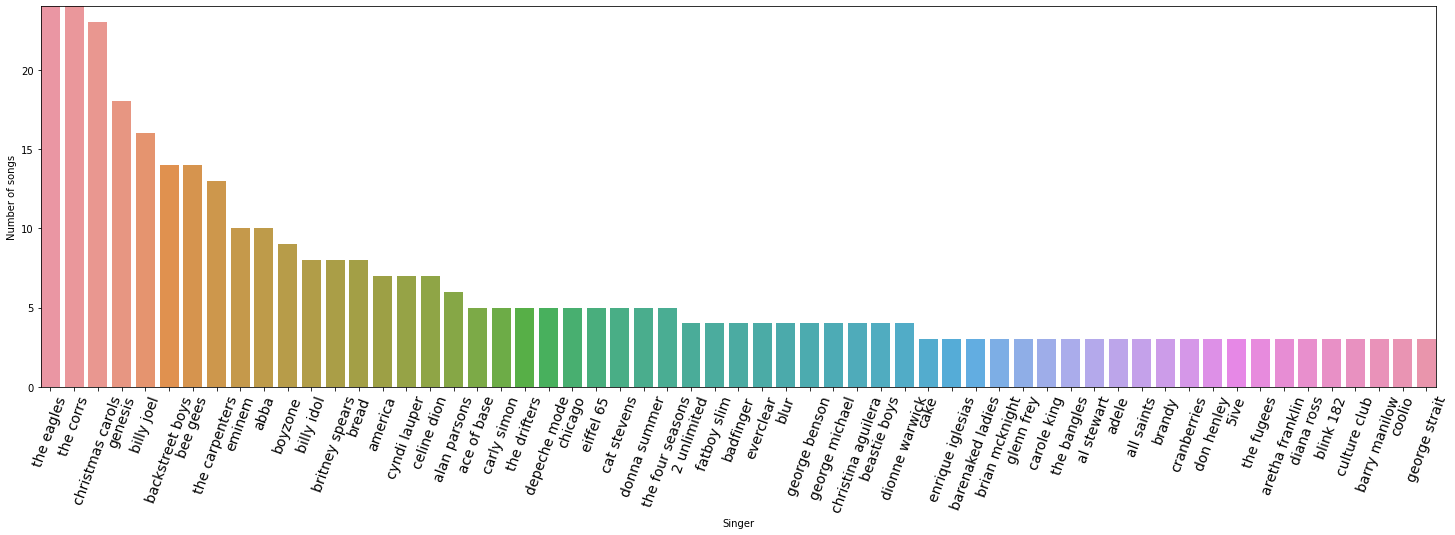

In [ ]:
plt.figure(figsize=(25,7))


sns.barplot(x=data_to_plot.iloc[:,0], y=data_to_plot.iloc[:,1])
plt.margins(x=0, y=0)
plt.xticks(fontsize=14, rotation=70)
plt.xlabel('Singer')
plt.ylabel('Number of songs')
plt.show()

# Preprocess data

### General preprocessing- cleaning the MIDI and Lyrics data

In [ ]:
def remove_corrupted_midi_files(data):
  corrupted_idx = []
  for i, midi in enumerate(data['Midi File']):
      try:
          midi = pretty_midi.PrettyMIDI(midis_path+ midi)
          midi.remove_invalid_notes()
      except:
          corrupted_idx.append(i)

  return data.drop(index=corrupted_idx)

print("shape before removing corrupted files: ", train_set.shape)
train_set = remove_corrupted_midi_files(train_set)
print("shape after removing corrupted files: ", train_set.shape)
test_set = remove_corrupted_midi_files(test_set)

shape before removing corrupted files:  (599, 5)


/usr/local/lib/python3.7/dist-packages/pretty_midi/pretty_midi.py:101: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


shape after removing corrupted files:  (589, 5)


### Preprocess lyrics & W2V embeddings

In [ ]:
train_set.iloc[10]["Lyrics"]

"it's not time to make a change   & just relax take it easy   & you're still young that's your fault   & there's so much you have to know   & find a girl settle down   & if you want you can marry   & look at me i am old but i'm happy   &    & i was once like you are now   & and i know that it's not easy   & to be calm when you've found   & something going on   & but take your time think a lot   & think of everything you've got   & for you will still be here tomorrow   & but your dreams may not   &    & how can i try to explain?   & when i do he turns away again   & it's always been the same same old story   & from the moment i could talk   & i was ordered to listen   & now there's a way   & and i know that i have to go away   & i know i have to go   &    & it's not time to make a change   & just sit down take it slowly   & you're still young that's your fault   & there's so much you have to go through   & find a girl settle down   & if you want you can marry   & look at me i am old but

In [ ]:
END_SENTENCE_TOKEN = '&'
END_SONG_TOKEN = '~'

def pretty_lyrics(tokenized_string):
    for token in tokenized_string:
        if token == END_SENTENCE_TOKEN:
            print('\n')
        else:
            print(token, end='')

pretty_lyrics(train_set.iloc[10]["Lyrics"])

it's not time to make a change   

 just relax take it easy   

 you're still young that's your fault   

 there's so much you have to know   

 find a girl settle down   

 if you want you can marry   

 look at me i am old but i'm happy   

    

 i was once like you are now   

 and i know that it's not easy   

 to be calm when you've found   

 something going on   

 but take your time think a lot   

 think of everything you've got   

 for you will still be here tomorrow   

 but your dreams may not   

    

 how can i try to explain?   

 when i do he turns away again   

 it's always been the same same old story   

 from the moment i could talk   

 i was ordered to listen   

 now there's a way   

 and i know that i have to go away   

 i know i have to go   

    

 it's not time to make a change   

 just sit down take it slowly   

 you're still young that's your fault   

 there's so much you have to go through   

 find a girl settle down   

 if you want you can mar

In [ ]:
def expend_contractions(word):
  return contractions.fix(word)

def tokenize_word(word):
  return word_tokenize(word)

def preprocess_word(word):
  word = expend_contractions(word)
  word = tokenize_word(word)
  return word

# tokenize each song while removing stopwords and checking the length
def tokenize_lyrics(df):
  return [[word for word in preprocess_word(d.lower()) if word not in punctuation and len(word)>=1] for d in df['Lyrics']]

lyrics_list = tokenize_lyrics(train_set.iloc[10:11])
pretty_lyrics(" ".join(lyrics_list[0]))

it is not time to make a change 

 just relax take it easy 

 you are still young that is your fault 

 there is so much you have to know 

 find a girl settle down 

 if you want you can marry 

 look at me i am old but i am happy 

 

 i was once like you are now 

 and i know that it is not easy 

 to be calm when you have found 

 something going on 

 but take your time think a lot 

 think of everything you have got 

 for you will still be here tomorrow 

 but your dreams may not 

 

 how can i try to explain 

 when i do he turns away again 

 it is always been the same same old story 

 from the moment i could talk 

 i was ordered to listen 

 now there is a way 

 and i know that i have to go away 

 i know i have to go 

 

 it is not time to make a change 

 just sit down take it slowly 

 you are still young that is your fault 

 there is so much you have to go through 

 find a girl settle down 

 if you want you can marry 

 look at me i am old but i am happy 

 

 all

In [ ]:
tokenized_lyrics_train = tokenize_lyrics(train_set)
tokenized_lyrics_test = tokenize_lyrics(test_set)

train_set['tokenized_lyrics'] = tokenized_lyrics_train
test_set['tokenized_lyrics'] = tokenized_lyrics_test
tokenized_lyrics = tokenized_lyrics_train + tokenized_lyrics_test

flat_tokenized_lyrics = [x for xs in tokenized_lyrics  for x in xs]
unique_tokwns = Counter(flat_tokenized_lyrics).keys()
num_of_words = len(unique_tokwns)
num_of_words

7451

In [ ]:
num_of_words_in_song = [len(x) for x in train_set['tokenized_lyrics']]
print('The mean number of words in song: ', np.mean(num_of_words_in_song))
train_set['number of words'] = num_of_words_in_song
sorted = train_set.sort_values(['number of words'], ascending=False)
# mean word count per singer for the top 20

groups = sorted.groupby('Singer')[list(['Singer', 'number of words'])]
# groups.aggregate('number of words')
count, means, singer = [], [], []
for key in groups.keys:
  group = groups.get_group(key)
  singer.append(key)
  count.append(len(group['number of words']))
  means.append(np.mean(group['number of words']))

df = pd.DataFrame()
df['singer'] = singer
df['num_songs'] = count
df['mean_word_count'] = means
df_to_plot = df.sort_values(['num_songs', 'mean_word_count'], ascending=False).iloc[:20,:]

The mean number of words in song:  314.3939899833055


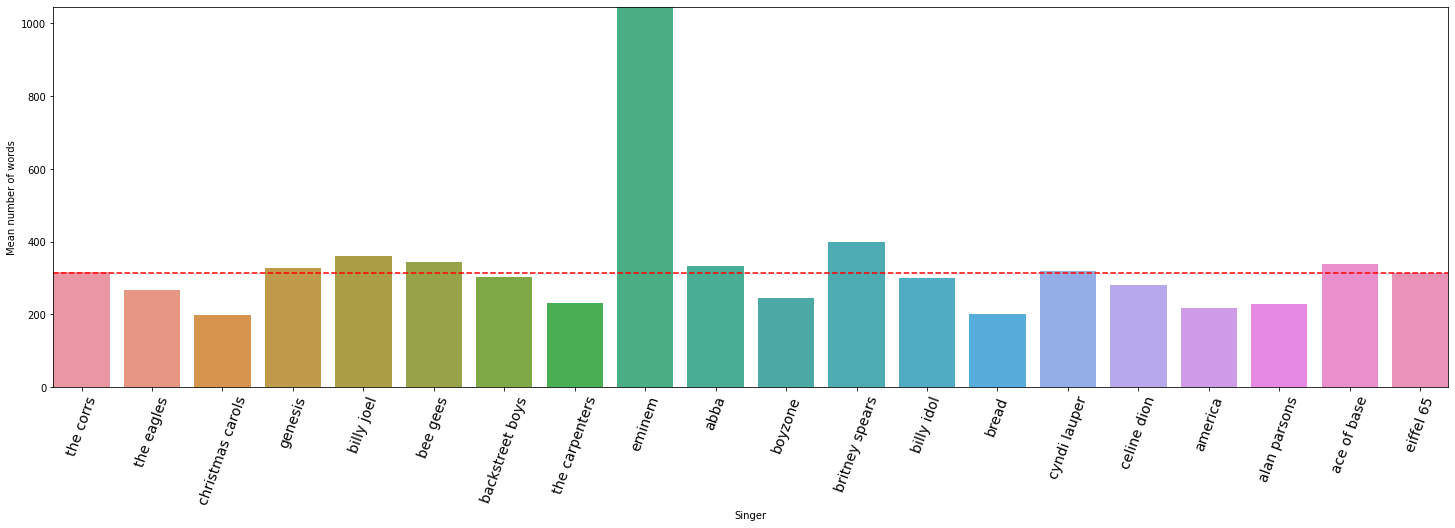

In [ ]:
plt.figure(figsize=(25,7))


sns.barplot(x=df_to_plot['singer'], y=df_to_plot['mean_word_count'])
plt.margins(x=0, y=0)
plt.xticks(fontsize=14, rotation=70)
plt.axhline(y=314, color='r', linestyle='--')
plt.xlabel('Singer')
plt.ylabel('Mean number of words')
plt.show()

In [ ]:
# lyrics preprocess
# work with word2vec!!
def get_embeddings_column(tokenized_lyrics_data):
  return np.array([np.array([w2v_model.wv[word] for word in x]) for x in tokenized_lyrics_data])


w2v_model = Word2Vec(tokenized_lyrics, min_count = 1,size = w2v_size, window = 5)
train_set['embeddins'] = get_embeddings_column(tokenized_lyrics_train)
test_set['embeddins'] = get_embeddings_column(tokenized_lyrics_test)

In [ ]:
# create embeddings matrix
def get_embedding_matrix(num_of_words, w2v_size):
  embedding_matrix = (np.random.rand(num_of_words+1, w2v_size) - 0.5) / 5.0
  for i, word in enumerate(unique_tokwns):
    emb = w2v_model.wv[word]
    embedding_matrix[i] = emb
  return embedding_matrix

embedding_matrix = get_embedding_matrix(num_of_words, w2v_size)
embedding_matrix.shape

(7388, 300)

In [ ]:
train_set.head(5)

,Singer,Song Name,Lyrics,Midi File,tokenized_lyrics,embeddins,full_melody
0,gerry rafferty,baker street,winding your way down on baker street & lite i...,Gerry_Rafferty_-_Baker_Street.mid,"[winding, your, way, down, on, baker, street, ...","[[-0.00053944316, -0.00060706004, 0.0015062637...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,gerry rafferty,right down the line,you know i need your love & you've got that ho...,Gerry_Rafferty_-_Right_Down_the_Line.mid,"[you, know, i, need, your, love, &, you, have,...","[[-0.13446623, -0.18740807, 0.2537194, -0.2647...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2 unlimited,tribal dance,come on check it out ya'll & (come on come on!...,2_Unlimited_-_Tribal_Dance.mid,"[come, on, check, it, out, ya, 'll, &, come, o...","[[-0.06541794, -0.09218886, 0.12340695, -0.128...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2 unlimited,let the beat control your body,let the beat control your body & let the beat ...,2_Unlimited_-_Let_the_Beat_Control_Your_Body.mid,"[let, the, beat, control, your, body, &, let, ...","[[-0.06634802, -0.09372027, 0.12463354, -0.132...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2 unlimited,get ready for this,ya'll ready for this? & get down with the styl...,2_Unlimited_-_Get_Ready_for_This.mid,"[ya, 'll, ready, for, this, &, get, down, with...","[[-0.012272625, -0.016389882, 0.021699335, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Preprocess Melodies (MIDI data)

In [ ]:
midi_data = pretty_midi.PrettyMIDI(midis_path+train_set['Midi File'][2])
midi_data

In [ ]:
midi_data.estimate_tempo(), midi_data.get_tempo_changes()

(257.1263568331014, (array([0.]), array([130.00013])))

In [ ]:
midi_data.get_beats().shape

(478,)

In [ ]:
midi_data.instruments

[Instrument(program=65, is_drum=False, name="ALTO SAX"),
 Instrument(program=33, is_drum=False, name="FINGERDBA"),
 Instrument(program=38, is_drum=False, name="SYN BASS "),
 Instrument(program=0, is_drum=False, name="A.PIANO 1"),
 Instrument(program=52, is_drum=False, name="CHOIR AAH"),
 Instrument(program=49, is_drum=False, name="SLOWSTRIN"),
 Instrument(program=29, is_drum=False, name="OVERDRIVE"),
 Instrument(program=55, is_drum=False, name="ORCH HIT"),
 Instrument(program=47, is_drum=False, name="TIMPANI"),
 Instrument(program=0, is_drum=True, name="DRUMS"),
 Instrument(program=119, is_drum=False, name="REVERSCYM")]

visualize the MIDI file via a piano roll, which is a time-frequency matrix where each row is a different MIDI pitch and each column is a different slice in time. pretty_midi can produce piano roll matrices for each indivual instrument (via Instrument.get_piano_roll) or the entire PrettyMIDI object (summed across instruments, via PrettyMIDI.get_piano_roll). The spacing in time between subsequent columns of the matrix is determined by the fs parameter.

/usr/local/lib/python3.7/dist-packages/librosa/display.py:1336: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  "Frequency axis exceeds Nyquist. "


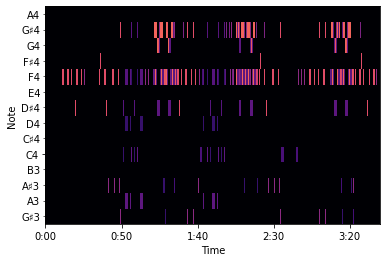

In [ ]:
import librosa.display

def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

plot_piano_roll(midi_data, 56, 70)


In [ ]:
def get_midis_info(data):
  frames_len = []
  max_notes_values = []

  for midi in data['Midi File'].values:
      pm = pretty_midi.PrettyMIDI(midis_path+ midi)
      pm.remove_invalid_notes()

      piano_roll = pm.get_piano_roll(fs=fs)
      if piano_roll.shape[1]:
          frames_n = piano_roll.shape[1]
          frames_len.append(frames_n)

      for inst in pm.instruments:
          piano_roll = inst.get_piano_roll(fs=fs)
          if piano_roll.shape[1]:
              max_note = piano_roll.max()
              max_notes_values.append(max_note)

  max_note = max(max_notes_values)
  min_length = min(frames_len)
  max_length = max(frames_len)
  mean_length = mean(frames_len)

  return [max_note, min_length, max_length, mean_length]


max_note, min_length, max_length, mean_length = get_midis_info(train_set)

print(f'maximum note value is {max_note}')
print(f'minimum song length is {min_length}')
print(f'maximum song length is {max_length}')
print(f'average song length is {mean_length}')

/usr/local/lib/python3.7/dist-packages/pretty_midi/pretty_midi.py:101: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


maximum note value is 762.0
minimum song length is 297
maximum song length is 3006
average song length is 1136.8505942275042


In [ ]:
def preprocess_melody_file(midi_path, midi_name, max_piano_note, fs=5):
    """create a single vectore that reprersents the entire melody"""
    pm = pretty_midi.PrettyMIDI(midi_path + midi_name)
    pm.remove_invalid_notes()
    
    # get notes from all instruments
    piano_all = pm.get_piano_roll(fs=fs)
    piano_shape = piano_all.shape
    
    # Normalize by the maximum value of a note
    piano_all = piano_all / max_piano_note
    
    # Normalize by the number of played notes in the same time
    count_notes = (piano_all > 0).sum(axis=1)
    count_notes[count_notes == 0] = 1
    melody = piano_all.sum(axis=1) / count_notes
    
    return melody

In [ ]:
def get_melodies(df):
  return [preprocess_melody_file(midis_path, x, max_note) for x in df['Midi File']]

train_set['full_melody'] = get_melodies(train_set)
test_set['full_melody'] = get_melodies(test_set)

/usr/local/lib/python3.7/dist-packages/pretty_midi/pretty_midi.py:101: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


In [ ]:
train_set.head(5)

,Singer,Song Name,Lyrics,Midi File,tokenized_lyrics,embeddins,full_melody
0,gerry rafferty,baker street,winding your way down on baker street & lite i...,Gerry_Rafferty_-_Baker_Street.mid,"[winding, your, way, down, on, baker, street, ...","[[0.00059564906, 0.0010584872, -0.00072733546,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,gerry rafferty,right down the line,you know i need your love & you've got that ho...,Gerry_Rafferty_-_Right_Down_the_Line.mid,"[you, know, need, your, love, you, have, got, ...","[[-0.015855113, -0.010515817, 0.016783938, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2 unlimited,tribal dance,come on check it out ya'll & (come on come on!...,2_Unlimited_-_Tribal_Dance.mid,"[come, on, check, it, out, ya, 'll, come, on, ...","[[-0.005503409, -0.0046078963, 0.0060208426, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2 unlimited,let the beat control your body,let the beat control your body & let the beat ...,2_Unlimited_-_Let_the_Beat_Control_Your_Body.mid,"[let, the, beat, control, your, body, let, the...","[[-0.004328131, -0.0043980614, 0.004244164, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2 unlimited,get ready for this,ya'll ready for this? & get down with the styl...,2_Unlimited_-_Get_Ready_for_This.mid,"[ya, 'll, ready, for, this, get, down, with, t...","[[-0.0010476017, -1.958512e-05, -0.00026946786...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


#### Split melody into segments

In [ ]:
ast=np.lib.index_tricks.as_strided
def generate_sliding_window_2d(arr, window_size=5, window_stride=1, last_window=False):
    last_window = 1 if last_window else 0
    arr = np.ascontiguousarray(arr)
    l0, l1 = arr.shape
    s0, s1 = arr.strides
    windows_num = ((l0-window_size)//window_stride) + last_window
    
    return ast(arr, (windows_num, window_size, l1), (s0*window_stride, s0, s1))

In [ ]:
ast=np.lib.index_tricks.as_strided
def generate_sliding_window(arr, window_size=5, window_stride=1, last_window=False):
    last_window = 1 if last_window else 0
    arr = np.ascontiguousarray(arr)
    arr_len = arr.shape[0]
    s, = arr.strides
    windows_num = ((arr_len-window_size)//window_stride) + last_window
    
    return ast(arr, (windows_num, window_size), (s*window_stride, s))

In [ ]:
def preprocess_melody_file_slided(midi_name, fs=5, max_piano_val=100, fpw=4, window_size=10):
    pm = pretty_midi.PrettyMIDI(midis_path+midi_name)
    pm.remove_invalid_notes()
    
    # Sum all notes from all instruments
    piano_all = pm.get_piano_roll(fs=fs)
    piano_shape = piano_all.shape

    # Normalize by the number of played instruments in the same time and note
    counter = np.zeros(piano_shape)
    for inst in pm.instruments:
        curr_piano = inst.get_piano_roll(fs=fs)

        counter[:, :curr_piano.shape[1]] += (curr_piano > 0).astype(int)

    counter[counter == 0] = 1
    piano_all /= counter
    
    # Normalize by the maximum value of a note
    piano_all = piano_all / max_piano_val
    
    # Normalize by the number of played notes in the same time
    count_notes = (piano_all > 0).sum(axis=0)
    count_notes[count_notes == 0] = 1
    melody = piano_all.sum(axis=0) / count_notes
    del piano_all
    
    # Split Melody's notes into words
    melody_per_word = generate_sliding_window(melody[(melody > 0).argmax():], window_size=fpw, window_stride=(fpw*4)//5, last_window=True)
    # Split Melody's words into windows
    # melody_windows = generate_sliding_window_2d(melody_per_word, window_size=window_size, last_window=True)
    
    return melody_per_word

In [ ]:
def melody_per_word(df):
  return [preprocess_melody_file_slided(x, window_size=1) for x in df['Midi File']]

train_set['melody_per_word'] = melody_per_word(train_set) 
test_set['melody_per_word'] = melody_per_word(test_set) 
train_set

/usr/local/lib/python3.7/dist-packages/pretty_midi/pretty_midi.py:101: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


,Singer,Song Name,Lyrics,Midi File,tokenized_lyrics,embeddins,full_melody,melody_per_word
0,gerry rafferty,baker street,winding your way down on baker street & lite i...,Gerry_Rafferty_-_Baker_Street.mid,"[winding, your, way, down, on, baker, street, ...","[[0.0013030592, -0.004090269, 0.0008233587, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.8671428571428572, 0.88, 0.9000000000000001..."
1,gerry rafferty,right down the line,you know i need your love & you've got that ho...,Gerry_Rafferty_-_Right_Down_the_Line.mid,"[you, know, i, need, your, love, &, you, have,...","[[0.21775734, -0.4504746, 0.49830502, -0.32945...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.83, 0.83, 0.8260000000000002, 0.845], [0.8..."
2,2 unlimited,tribal dance,come on check it out ya'll & (come on come on!...,2_Unlimited_-_Tribal_Dance.mid,"[come, on, check, it, out, ya, 'll, &, come, o...","[[0.44903523, -0.6026171, 0.012530835, -0.4995...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.44, 0.0, 0.46, 0.54], [0.54, 0.5, 0.47, 0...."
3,2 unlimited,let the beat control your body,let the beat control your body & let the beat ...,2_Unlimited_-_Let_the_Beat_Control_Your_Body.mid,"[let, the, beat, control, your, body, &, let, ...","[[0.44092643, -0.5675243, 0.2601113, -0.216100...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.83, 0.0, 0.83, 0.82], [0.82, 0.82, 0.82, 0..."
4,2 unlimited,get ready for this,ya'll ready for this? & get down with the styl...,2_Unlimited_-_Get_Ready_for_This.mid,"[ya, 'll, ready, for, this, &, get, down, with...","[[0.00923968, -0.15556464, 0.10145177, -0.5820...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.3692818509615385, 0.3692818509615385, 0.36..."
...,...,...,...,...,...,...,...,...
594,don henley,dirty laundry,i make my living off the evening news & just g...,Don_Henley_-_Dirty_Laundry.mid,"[i, make, my, living, off, the, evening, news,...","[[0.06159106, -0.3643866, 0.43834803, -0.46954...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.79, 0.79, 0.79, 0.79], [0.79, 0.79, 0.79, ..."
595,don henley,new york minute,harry got up & dressed all in black & went dow...,Don_Henley_-_New_York_Minute.mid,"[harry, got, up, &, dressed, all, in, black, &...","[[-0.003911188, -0.001092173, 6.470319e-05, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.5549999999999999, 0.5549999999999999, 0.55..."
596,bob dylan,subterranean homesick blues,johnny's in the basement & mixing up the medic...,Bob_Dylan_-_Subterranean_Homesick_Blues.mid,"[johnny, 's, in, the, basement, &, mixing, up,...","[[-0.0044127405, -0.002254767, -0.0017805406, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[1.0233333333333334, 1.0233333333333334, 1.02..."
597,goldfinger,mable,i met her sunday that was yesterday & the girl...,Goldfinger_-_Mable.mid,"[i, met, her, sunday, that, was, yesterday, &,...","[[0.06159106, -0.3643866, 0.43834803, -0.46954...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0], [..."


Split data

In [ ]:
# split into train and validation

train_index = np.random.rand(len(train_set)) > VALIDATION_FRAC

train = train_set[train_index]
val = train_set[~train_index]

train.shape

(470, 8)

In [ ]:
tokens_encoding_dict = {}
inverse_tokens_encoding_dict = {}
for i, token in enumerate(sorted(unique_tokwns)):
  tokens_encoding_dict[token] = i
  inverse_tokens_encoding_dict[i] = token

In [ ]:
def get_one_hot_for_y(data, i, j, vocab_size):
  y = np.zeros(vocab_size)
  lyric = data.iloc[i]['tokenized_lyrics']
  word = lyric[j]
  y[tokens_encoding_dict[word]] = 1
  return y

In [ ]:
# melody_type: string, 'full_melody' or 'melody_per_word' 

def get_X_Y(data, vocab_size, melody_type):
  X_e, X_m, Y = [],[], []
  embeddings = data['embeddins']
  melodies = data[melody_type]
  for i, e in enumerate(embeddings):
    for j, word in enumerate(e):
      if j+1 < len(e):
        if melody_type == 'melody_per_word':
          if j < melodies.iloc[i].shape[0]:
            X_e.append(np.array(word))
            X_m.append(np.array(melodies.iloc[i][j]))
            Y.append(get_one_hot_for_y(data, i, j+1, vocab_size))
        else:
          X_e.append(np.array(word))
          X_m.append(np.array(melodies.iloc[i]))
          Y.append(get_one_hot_for_y(data, i, j+1, vocab_size))
        
  return (np.array(X_e), np.array(X_m)), np.array(Y)


# Model

In [ ]:
def creat_model(melody_vec_size, window_size,lyrics_vec_size, max_num_of_words, vec_size=None, embeddings=None, dropout=0.2):
  melody_input = Input(shape=(window_size, melody_vec_size), name='melody')
  input_lyrics = Input(shape=(window_size, lyrics_vec_size), name='lyrics')

  concat = Concatenate(axis=2, name='concatenate')([melody_input, input_lyrics])
  
  X = LSTM(64, return_sequences=True, dropout=dropout)(concat)
  X = LSTM(64, dropout=dropout)(X)
  X = Dense(128, activation="relu")(X)
  X = Dropout(dropout)(X)
  # X = Flatten()(X)
  out = Dense(max_num_of_words, activation="softmax", name = 'out')(X)

  model = Model([melody_input, input_lyrics], out)
  model.compile(loss='categorical_crossentropy', optimizer=Adam())
    
  return model


In [ ]:
def creat_model_2(melody_vec_size, window_size,lyrics_vec_size, max_num_of_words, vec_size=None, embeddings=None, dropout=0.3):
  melody_input = Input(shape=(window_size, melody_vec_size), name='melody')
  input_lyrics = Input(shape=(window_size, lyrics_vec_size), name='lyrics')

  concat = Concatenate(axis=2, name='concatenate')([melody_input, input_lyrics])
  
  X = LSTM(64, return_sequences=True, dropout=dropout)(concat)
  X = LSTM(64, return_sequences=True, dropout=dropout)(X)
  X = LSTM(64, dropout=dropout)(X)
  X = Dense(128, activation="relu")(X)
  X = Dropout(dropout)(X)
  # X = Flatten()(X)
  out = Dense(max_num_of_words, activation="softmax", name = 'out')(X)

  model = Model([melody_input, input_lyrics], out)
  model.compile(loss='categorical_crossentropy', optimizer=Adam())
    
  return model


In [ ]:
def get_callbacks(model_name):
    metric = 'val_loss'
    metric_mode = 'min'
    earlystop = EarlyStopping(monitor=metric, mode=metric_mode, verbose=1, patience=20)
    reduceLR = ReduceLROnPlateau(monitor = metric, mode = metric_mode, patience = 5,factor = 0.5, min_lr = 1e-6, verbose = 1)
    checkpoint = ModelCheckpoint(fr'./models/{model_name}.h5', monitor=metric, save_best_only=True, mode=metric_mode)

    return checkpoint, reduceLR, earlystop

def train_model(model_name, model, train_data, val_data, params_dict=None):
    os.makedirs('./models', exist_ok=True)
    params = ''
    if params_dict is not None:
        params = '_'.join(f'{key}_{val}' for key,val in params_dict.items())
    model_name = f'_{model_name}' + f'_{params}'
        
    callbacks = get_callbacks(model_name)
  
    (train_x_embedding, train_x_melody), train_y = train_data
    (val_x_embedding, val_x_melody), val_y = val_data

    # model_gen = model_gen(*train_x_melody.shape[1:],*train_x_embedding.shape[1:] ) # melody size
    history = model.fit(
                        x=(
                            train_x_melody.reshape(train_x_melody.shape[0],1, train_x_melody.shape[1]),
                            train_x_embedding.reshape(train_x_embedding.shape[0],1, train_x_embedding.shape[1]),
                        ),
                        y=train_y,
                        validation_data=[
                                         (val_x_melody.reshape(val_x_melody.shape[0],1, val_x_melody.shape[1]), 
                                          val_x_embedding.reshape(val_x_embedding.shape[0],1, val_x_embedding.shape[1])),
                                          val_y],
                        batch_size=params_dict['batch_size'],
                        epochs=params_dict['epochs'],

                        callbacks=callbacks,
                        verbose=1
                        )
        
    history = history.history

    return model, history

In [ ]:
def plot_loss(history):
    ncols = 1
    for k in ['val_loss', 'loss']:
      plt.plot(history[k])

    plt.title("Model's loss over epochs- loss metric: binary crossentropy")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(['validation loss', 'train loss'])    
    plt.show()

### Full melody model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 melody (InputLayer)            [(None, 1, 128)]     0           []                               
                                                                                                  
 lyrics (InputLayer)            [(None, 1, 300)]     0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 1, 428)       0           ['melody[0][0]',                 
                                                                  'lyrics[0][0]']                 
                                                                                                  
 lstm (LSTM)                    (None, 1, 64)        126208      ['concatenate[0][0]']        

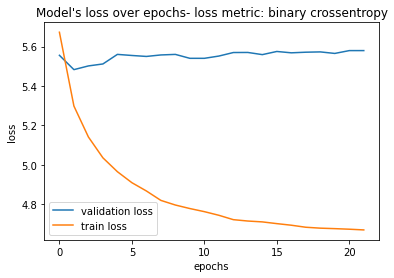

In [ ]:
model_full = creat_model(melody_vec_size=128, window_size=1, lyrics_vec_size=w2v_size, max_num_of_words=num_of_words)
print(model_full.summary())
plot_model(model_full)
plt.show()
params = {'batch_size': 32, 'epochs': 50}
train_x_y = get_X_Y(train, num_of_words ,'full_melody')
val_x_y = get_X_Y(val, num_of_words,'full_melody')
model_entire_melody, history_entire_melody = train_model('entire_melody',
                                                         model_full, 
                                                         train_x_y, 
                                                         val_x_y, 
                                                         params_dict=params)
del(train_x_y)
del(val_x_y)

plot_loss(history_entire_melody)

### Model per word

Epoch 1/50
4122/4122 [==============================] - 36s 8ms/step - loss: 5.6066 - val_loss: 5.4908 - lr: 0.0010
Epoch 2/50
4122/4122 [==============================] - 29s 7ms/step - loss: 5.2062 - val_loss: 5.3979 - lr: 0.0010
Epoch 3/50
4122/4122 [==============================] - 29s 7ms/step - loss: 4.9971 - val_loss: 5.3862 - lr: 0.0010
Epoch 4/50
4122/4122 [==============================] - 29s 7ms/step - loss: 4.8509 - val_loss: 5.4008 - lr: 0.0010
Epoch 5/50
4122/4122 [==============================] - 29s 7ms/step - loss: 4.7473 - val_loss: 5.4174 - lr: 0.0010
Epoch 6/50
4122/4122 [==============================] - 30s 7ms/step - loss: 4.6736 - val_loss: 5.4285 - lr: 0.0010
Epoch 7/50
4122/4122 [==============================] - 30s 7ms/step - loss: 4.6119 - val_loss: 5.4371 - lr: 0.0010
Epoch 8/50
4115/4122 [============================>.] - ETA: 0s - loss: 4.5646
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4122/4122 [======================

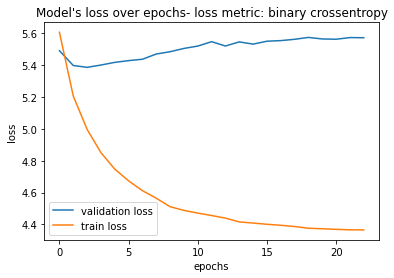

In [ ]:
train_x_y = get_X_Y(train, num_of_words ,'melody_per_word')
val_x_y = get_X_Y(val, num_of_words,'melody_per_word')
model_per_word = creat_model(melody_vec_size=4, window_size=1, lyrics_vec_size=w2v_size, max_num_of_words=num_of_words)
model_melody_per_word, history_melody_per_word = train_model('melody_per_word',
                                                         model_per_word, 
                                                         train_x_y, 
                                                         val_x_y, 
                                                         params_dict=params)
del(train_x_y)
del(val_x_y)

plot_loss(history_melody_per_word)

# Songs Generator

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_lyrics)

In [ ]:
def generate_next_word(model, word, melody_vec, num_of_words):
    embedding = w2v_model.wv[word]
    probs = model.predict((melody_vec.reshape(1, 1, melody_vec.shape[0]), embedding.reshape(1, 1, embedding.shape[0])))
    probs = np.asarray(probs).astype('float64')
    probs /= np.sum(probs)
    chosen_idx = np.random.choice(range(0, num_of_words), p=probs[0])
    # chosen_idx = np.argmax(probs)
    chosen_word = inverse_tokens_encoding_dict[chosen_idx]
    return chosen_idx, chosen_word

def get_melody_vec(preprocess_type, idx, melody):
  # if preprocess_type == "entire_melody":
  return melody[idx]
  # else:
    # return None

def generate_song(model, melody, word, window_size, tokenizer, max_song_len, preprocess_type="entire_melody"):
  word = preprocess_word(word.lower())[0]
  song = []

  i = 0

  while i < max_song_len:
      song.append(word)
      i+=1
      melody_vec = get_melody_vec(preprocess_type, i, melody)
      idx, word = generate_next_word(model, word, melody_vec, num_of_words)
  return ' '.join(song)

In [ ]:
def generate_songs_test(model, test_set, first_word=None, melody_type='melody_per_word'):
  for index, row in test_set.iterrows():
    init_word = first_word if first_word else row['Lyrics'].split()[0]
    (embedding, melody_vec), y = get_X_Y(pd.DataFrame(row).T, num_of_words, melody_type)
    song = generate_song(model, melody_vec, init_word, window_size=1, tokenizer=tokenizer, max_song_len=50, preprocess_type="entire_melody")
    pretty_song = pretty_lyrics(song)
    print(row)
    print(pretty_song)
    print("#######")

## melody representation - the entire melody


In [ ]:
word = "your"
(embedding, melody_vec), y = get_X_Y(pd.DataFrame(val.iloc[0]).T, num_of_words,'full_melody')
generate_song(model_entire_melody, melody_vec, word, window_size=1, tokenizer=tokenizer, max_song_len=50, preprocess_type="entire_melody")

'your cares for the air & old lives to see i play to make again i are put them all by i turn this to talk you one is killing think you own in this all around what they are like born & now & all it times that do'

### First word: the original one



In [ ]:
generate_songs_test(model_entire_melody, test_set, first_word=None, melody_type='full_melody')

close to 

 i am you 

 so mellow christmas bitch 

 it quite you can be the air your lips 

 my voice of time 

 tonight 

 there is looking baby baby yeah 

 no more tears strong 

 what i give me every 

 i did notSinger                                                    the bangles
Song Name                                               eternal flame
Lyrics               close your eyes give me your hand darling & d...
Midi File                             The_Bangles_-_Eternal_Flame.mid
tokenized_lyrics    [close, your, eyes, give, me, your, hand, darl...
embeddins           [[0.05264265, -0.17516586, 0.09501888, -0.2266...
full_melody         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
melody_per_word     [[1.18, 1.13, 1.13, 1.18], [1.18, 1.18, 1.06, ...
Name: 0, dtype: object
None
#######
if do 

 in life through his apartment 

 laugh 

 better i am want out in mine 

 five 

 what you all with 

 you just fallen and left to the desert 

 it 

 another gold teacher about 

### First word: "love"

In [ ]:
generate_songs_test(model_entire_melody, test_set, first_word="Love",melody_type='full_melody')

love i am like the dream 

 see is dear it you are going to feel me somebody when you have you could be i think a letter to lean to say 

 the keys days coz 

 true you do not you this hot before 

 you what isSinger                                                    the bangles
Song Name                                               eternal flame
Lyrics               close your eyes give me your hand darling & d...
Midi File                             The_Bangles_-_Eternal_Flame.mid
tokenized_lyrics    [close, your, eyes, give, me, your, hand, darl...
embeddins           [[0.05264265, -0.17516586, 0.09501888, -0.2266...
full_melody         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
melody_per_word     [[1.18, 1.13, 1.13, 1.18], [1.18, 1.18, 1.06, ...
Name: 0, dtype: object
None
#######
love was always be the game with the line 

 when bad 

 people stall in his room 

 you reach 

 because i got wrong i want to try like many closer oh oh yeah 

 you in the times this color in 

### First word: "baby"

In [ ]:
generate_songs_test(model_entire_melody, test_set, first_word="baby",melody_type='full_melody')

baby again it will not a apartment i am right she ever i want it late girl everything to dance under like they wonder a song right we both 

 and i will be it snow and if i just your do not so not hurt here just no isSinger                                                    the bangles
Song Name                                               eternal flame
Lyrics               close your eyes give me your hand darling & d...
Midi File                             The_Bangles_-_Eternal_Flame.mid
tokenized_lyrics    [close, your, eyes, give, me, your, hand, darl...
embeddins           [[0.05264265, -0.17516586, 0.09501888, -0.2266...
full_melody         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
melody_per_word     [[1.18, 1.13, 1.13, 1.18], [1.18, 1.18, 1.06, ...
Name: 0, dtype: object
None
#######
baby i do you got hard again 

 from day 

 ja me cut by until then love it for me tell divides 

 alright in the years was thing my door way it that for comin 

 does we saw in hell 

 c

### First word: "happy"

In [ ]:
generate_songs_test(model_entire_melody, test_set, first_word="happy", melody_type='full_melody')

happy they want to your clown to provide and believe in a genie more times same 

 i ever afraid me 

 duke 

 two to pay is clear 

 love me the line 

 a trash he do not out of the world for me the thing 

 iSinger                                                    the bangles
Song Name                                               eternal flame
Lyrics               close your eyes give me your hand darling & d...
Midi File                             The_Bangles_-_Eternal_Flame.mid
tokenized_lyrics    [close, your, eyes, give, me, your, hand, darl...
embeddins           [[0.05264265, -0.17516586, 0.09501888, -0.2266...
full_melody         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
melody_per_word     [[1.18, 1.13, 1.13, 1.18], [1.18, 1.18, 1.06, ...
Name: 0, dtype: object
None
#######
happy i am the music are always looks 

 it when the kiss 

 we heard me up it all my mind 

 ten need me to try 

 i need a victim 

 quit to take to pray me 

 to hold stand 

 there never you

## melody representation - Melody per word

In [ ]:
word = "your"
(embedding, melody_vec), y = get_X_Y(pd.DataFrame(val.iloc[0]).T, num_of_words,'melody_per_word')
generate_song(model_melody_per_word, melody_vec, word, window_size=1, tokenizer=tokenizer, max_song_len=50, preprocess_type="")

"your lover you & born & this is not think my lover i want to have a new 's killing & & the heart & take you think this world & can be given & i miss you i have to have changed was real & well you all the"

### First word: the original one



In [ ]:
generate_songs_test(model_melody_per_word, test_set, first_word=None, melody_type='melody_per_word')

close 

 wrap cupid on and fine to pray that i am a brother 

 woah 

 with evil 

 in your that he will start happy that is like you for it do not killing 

 is nothing let it feels 

 every 

 west doing you could beSinger                                                    the bangles
Song Name                                               eternal flame
Lyrics               close your eyes give me your hand darling & d...
Midi File                             The_Bangles_-_Eternal_Flame.mid
tokenized_lyrics    [close, your, eyes, give, me, your, hand, darl...
embeddins           [[-0.034162007, 0.030340679, 0.009093242, 0.05...
full_melody         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
melody_per_word     [[1.18, 1.13, 1.13, 1.18], [1.18, 1.18, 1.06, ...
Name: 0, dtype: object
None
#######
if a feel i like more just find niggas listen to thank 

 and buy please love is fine has window to know 

 throw 

 i know you cry through 

 hunger can get us 

 blue and now the city 

### First word: "love"

In [ ]:
generate_songs_test(model_melody_per_word, test_set, first_word="Love",melody_type='melody_per_word')

love you 

 i was you with you are not i was tha 

 i would not get it is all you took like right 

 and baby did you do not get to hide 

 look by brother through the course are going for i got to the danceSinger                                                    the bangles
Song Name                                               eternal flame
Lyrics               close your eyes give me your hand darling & d...
Midi File                             The_Bangles_-_Eternal_Flame.mid
tokenized_lyrics    [close, your, eyes, give, me, your, hand, darl...
embeddins           [[-0.034162007, 0.030340679, 0.009093242, 0.05...
full_melody         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
melody_per_word     [[1.18, 1.13, 1.13, 1.18], [1.18, 1.18, 1.06, ...
Name: 0, dtype: object
None
#######
love tonight with the pieces is just the name of life 

 but my arms 

 but please 

 kick 

 abacab 

 take it was i am 

 you are so to let me would time 

 shoe in your 

 she is love you say a 

### First word: "baby"

In [ ]:
generate_songs_test(model_melody_per_word, test_set, first_word="baby",melody_type='melody_per_word')

baby 

 in the old a lot me 

 just want to 

 she always them that you did i got a 

 and give me when i turned 

 i will drag just sit 

 no 

 i could go if i do not even that one 

 becauseSinger                                                    the bangles
Song Name                                               eternal flame
Lyrics               close your eyes give me your hand darling & d...
Midi File                             The_Bangles_-_Eternal_Flame.mid
tokenized_lyrics    [close, your, eyes, give, me, your, hand, darl...
embeddins           [[-0.034162007, 0.030340679, 0.009093242, 0.05...
full_melody         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
melody_per_word     [[1.18, 1.13, 1.13, 1.18], [1.18, 1.18, 1.06, ...
Name: 0, dtype: object
None
#######
baby 

 a place 

 it is so come on your shoes through you cry you got in the church my loneliness 

 girl 

 around let me help khan or me because i feel them from these 

 there is crazy make baby about waits 

### First word: "happy"

In [ ]:
generate_songs_test(model_melody_per_word, test_set, first_word="happy", melody_type='melody_per_word')

happy 

 on the route 

 all you can not hear 

 because i can feel her said you know what they got as new wish 

 and your place for the end are losing 

 on the blinds at you do not give me the end of hollywood ofSinger                                                    the bangles
Song Name                                               eternal flame
Lyrics               close your eyes give me your hand darling & d...
Midi File                             The_Bangles_-_Eternal_Flame.mid
tokenized_lyrics    [close, your, eyes, give, me, your, hand, darl...
embeddins           [[-0.034162007, 0.030340679, 0.009093242, 0.05...
full_melody         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
melody_per_word     [[1.18, 1.13, 1.13, 1.18], [1.18, 1.18, 1.06, ...
Name: 0, dtype: object
None
#######
happy i would be the city all around me 

 but i am you that i will never 

 do not you are going to dance from all the dub to my car on my oh yeah yeah yeah 

 when i will want to take for